In [1]:
from LangGraphAgent import LangGraphAgentSystem
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from dotenv import load_dotenv
import os
from openai import AzureOpenAI
from pydantic import BaseModel
from langfuse import Langfuse
from langfuse.callback import CallbackHandler
from pydantic import BaseModel, Field
import pandas as pd
import json

In [2]:

# Final Pydantic Structured Output Classes for Minimal Agent Workflow
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")

class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

# An input dictionary for the
input_dict = {
    "input_prompt":"what's the weather in SF?",
    "agent_prompt":"You are a helpful assistant! Your name is Bob.",
    "agent_state":AgentState,
    "structured_output_class":WeatherResponse
}


# Create a subclass for LangGraphAgentSystem to inherit all functionality, but override tools with a custom tooling. 
class CustomAgentWorkflow(LangGraphAgentSystem):
    def create_tools(lg):
        @tool
        def get_weather(city: Literal["nyc", "sf"]):
            """Use this to get weather information."""
            if city == "nyc":
                return "It is cloudy in NYC, with 1000 mph winds in the North-East direction and a temperature of 70 degrees"
            elif city == "sf":
                return "It is 75 degrees and sunny in SF, with 1000 mph winds in the South-East direction"
            else:
                raise AssertionError("Unknown city")

        tools = [get_weather]
        lg.tools = tools

# instantiate
caw = CustomAgentWorkflow(input_dict)

# run orchestrating method for the workflow
answer = caw.run()

# display output
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='fb7f3005-6c8d-4b6a-b974-bbedb09063aa'),
  SystemMessage(content='You are a helpful assistant! Your name is Bob.', additional_kwargs={}, response_metadata={}, id='468365b4-3b55-4c2e-a838-23663c93d9e1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7KzC2Bi4QLvFtsmsM9PsfIs3', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 73, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False,

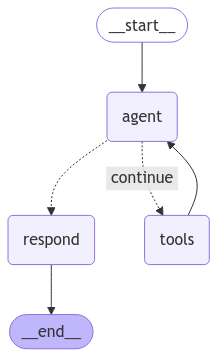

In [5]:
caw.graph

# Generalization

In [21]:

class SugarClass(BaseModel):
    """Respond to the user with this"""
    ingredients: str = Field(description="The sugar amount of the product")
    explanation: str = Field(description="An explanation of your reasoning")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: SugarClass


input_dict = {
    "input_prompt":"what's the sugar content in okanaya?",
    "agent_prompt":"You are a helpful assistant! Make sure to use your tool.",
    "agent_state":AgentState,
    "structured_output_class":SugarClass
}


# override create tools with a custom tooling.. 
class MyLG(LangGraphAgentSystem):
    def create_tools(self):
        @tool
        def get_sugar(product: Literal["okanaya", "cabaya"]):
            """Use this to get weather information."""
            if product == "cabaya":
                return "There is 1000 g of sugar in cabaya."
            elif product == "okanaya":
                return "There is 1g of sugar in okanaya "
            else:
                raise AssertionError("Unknown city")

        tools = [get_sugar]
        self.tools = tools

lg = MyLG(input_dict)

answer = lg.run()

answer

{'messages': [HumanMessage(content="what's the sugar content in okanaya?", additional_kwargs={}, response_metadata={}, id='72ba245b-5731-49de-ae91-a9d46f4da43e'),
  SystemMessage(content='You are a helpful assistant! Make sure to use your tool.', additional_kwargs={}, response_metadata={}, id='7d103249-6e30-447f-8674-e60e404d5765'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1f1H6EO7AHDVpktt0Twwj2Zh', 'function': {'arguments': '{"product":"okanaya"}', 'name': 'get_sugar'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 80, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {

In [6]:
df = pd.read_csv("test_inputs/test.csv")

# Generalization to Finalizer Agent

In [27]:
class ResponseSO(BaseModel):
    is_detected_inconsistency: bool
    inconsistency_explanation: str

class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: ResponseSO

# Get System Prompt
system_prompt = f'''

You are an intelligent agent responsible for evaluating the internal consistency of data extracted by a product scanner for ingredients, allergens, and nutrition. 
You will leverage **predefined tools** to detect inconsistencies and apply deterministic business logic corrections when appropriate. 
Iterate only up to 3 times if necessary. 

### Responsibilities:

1. **Applying Business Logic Corrections**:
   - Use the predefined `apply_business_logic` tool to resolve inconsistent or undetermined fields based on deterministic rules. You can also suggest additional things to fix based on
   your field 'inconsistency_explanation', which we can review later and potentially incorporate.
   - Examples of business logic include:
     - If "Milk = Yes," then "Vegan = No."
     - If "Eggs = Yes," then "Vegan = No."
     - Wheat = Yes and Gluten_Free = Yes are inconsistent.

2. **Decision-Making**:
   - For each product:
     - First, evaluate whether to call the `apply_business_logic` tool to resolve undetermined fields or correct inconsistencies. 
     - Ensure that all fixes are logged with justifications.

3. **Output Requirements**:
   - For each product, return a JSON object with the following fields:
     - `is_detected_inconsistency` (Boolean): Indicates whether an inconsistency was detected in the input data.
     - `inconsistency_explanation` (String): Explanation of your suggestion for applied fixes.

4. **Execution Guidelines**:
   - Always use the predefined tool `apply_business_logic` when evaluating data.
   - Return concise, actionable output with appropriate justifications for each step.

'''


# Get Input Prompt
df = pd.read_csv('test_inputs/test.csv')

input_text = str(df.to_dict(orient='records'))


# Define Inputs
input_dict = {
    "input_prompt":input_text,
    "agent_prompt":system_prompt,
    "agent_state":AgentState,
    "structured_output_class":ResponseSO,
    "df":df
}


# override create tools with a custom tooling.. 
class AlignmentAgent(LangGraphAgentSystem):
    def create_tools(self):
        @tool
        def apply_business_logic():
            """
            Applies business logic rules to update the DataFrame with implied values where appropriate.

            Parameters:
            - df (pd.DataFrame): The main dataframe to update.
            Returns:
            - pd.DataFrame: Updated dataframe with implied values applied where necessary.
            """

            # Save dataframe as internal class attribute
            self.df = self.input_dict['df']

            # Apply pre-determined business logic implications
            business_logic_rules = {
                "Attribute": ["Wheat", "Milk", "No_Sugar_Added", "Milk", "Eggs", "Shellfish", "Vegan"],
                "Value": ["Yes", "Yes", "No", "Yes", "Yes", "Yes", "Yes"],
                "Implied Attribute": ["Gluten-Free", "Vegan", "Sugar-Free", "Lactose-Free", "Vegan", "Vegan", "Vegetarian"],
                "Implied Value": ["No", "No", "No", "No", "No", "No", "Yes"]
            }
            

            # Convert business logic rules into a DataFrame
            business_logic_df = pd.DataFrame(business_logic_rules)
            logic_applied = False

            # Iterate through the business logic rules
            outcomes = []
            for _, rule in business_logic_df.iterrows():
                # Check if the main attribute matches the specified value
                condition = (self.df[rule["Attribute"]] == rule["Value"])
                if condition.any():
                    logic_applied = True  # Set the flag to True if any condition is met
                    # Update the implied attribute with the implied value where the condition is met
                    self.df.loc[0, rule["Implied Attribute"]] = rule["Implied Value"]
                    outcomes.append( str(rule["Attribute"]) + ":" + str(rule['Value']) + " -> " +  str(rule["Implied Attribute"])  + ":" + str(rule['Implied Value']) )

                # Update the implied attribute with the implied value where the condition is met
                self.df.loc[0, rule["Implied Attribute"]] = rule["Implied Value"]

            # Save output df
            self.output_df = self.df

            return {
                "outcomes":outcomes,
                "df":self.df
                }

        tools = [apply_business_logic]
        self.tools = tools

agent = AlignmentAgent(input_dict)
answer = agent.run()
try:
    agent_output = json.loads(answer['messages'][-1].content.replace('```','').replace('json',''))
except:
    agent_output = {
        "is_detected_inconsistency": False,
        "inconsistency_explanation": "LLM call did not use tool or had structured output failure",
        "output": answer['messages'][-1].content,
    }
agent_output


{'is_detected_inconsistency': True,
 'inconsistency_explanation': "The business logic applied corrected the following inconsistencies: 'Milk: Yes' implies 'Vegan: No' and 'Lactose-Free: No'. These corrections were made to ensure consistency in the data."}

In [8]:
agent.output_df.to_dict(orient='records')

[{'Unnamed: 0': 0,
  'Unnamed: 1': 156,
  'SKU': 1036,
  'Product Name': 'Hersheys Milk Chocolate with Almonds (1.45oz)',
  'Size UOM': '1.45 oz',
  'Manufacturer': 'Hershey',
  'SKU Product Group': '01-CANDY',
  'Market SAP Category': '01-CANDY',
  'Vend SAP Category': '01-CANDY',
  'OCS SAP Category': '01-CANDY',
  'SKU Merchandise Category': 'Candy',
  'SKU Merchandise Class': nan,
  'Product Type Name': 'Product',
  'Product Item ID': 37,
  'Package': 'Each',
  'Package Qty': 1,
  'Barcode': 34000002412,
  'is_nutrition_over_75_percent_undetermined': False,
  'is_nutrition_over_100_percent_undetermined': False,
  'Product_Name_Scraped': "Hershey's Milk Chocolate with Whole Almonds",
  'Serving_Size': '1 bar (1.45 oz)',
  'Servings_Per_Container': 1,
  'Calories': 210,
  'Total_Fat': '14g',
  'Saturated_Fat': '7g',
  'Trans_Fat': '0g',
  'Cholesterol': '10mg',
  'Sodium': '30mg',
  'Total_Carbohydrate': '22g',
  'Dietary_Fiber': '2g',
  'Total_Sugars': '20g',
  'Added_Sugars': '17g'

# Generalization to Dynamic Retry Validator Agent